In [1]:
# Import these packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom as pdicom
import cv2

In [10]:
## Load the original csv as labels_df

#pth='/media/sumanth/MY DRIVE/'
pth=''
cs1= pd.read_csv(pth+'calc_case_description_test_set.csv',index_col=False)
cs2= pd.read_csv(pth+'calc_case_description_train_set.csv',index_col=False)
cs3=pd.concat([cs1,cs2])

# Removing cases of Benign without callback cases
cs3=cs3[cs3['pathology']!='BENIGN_WITHOUT_CALLBACK']

# There is a trailing line break at the end of each image's path which is removed here
cs3['ROI mask file path']=pth+'DOI/'+cs3['ROI mask file path']

# Create empty dataframe first
labels_df=pd.DataFrame()

# Read & Display images
for x in range(cs3.shape[0]):
    row=cs3.iloc[x]
    imgloc=row['ROI mask file path']
    try:
        img=pdicom.read_file(imgloc,force=True)
        labels_df=labels_df.append(row,ignore_index=True) 
    except:
        pass
print('# of Images present:',labels_df.shape[0])
print('# of Images missing:',cs3.shape[0]-labels_df.shape[0])
print('Total:',cs3.shape[0])

# of Images present: 2
# of Images missing: 1329
Total 1331


In [25]:
# Create new CSV with the images stored with it as newcsv and stored as newcsv.pkl
from skimage.transform import rotate

# Calculate mean pixel array
def preprocess_image(path):
    img=pdicom.read_file(path,force=True)
    imgpix=img.pixel_array

    # Scaling 16-bit pixel to 8-bits
    imgpix=((imgpix/65535)*255).astype(np.uint8)

    # Contrast enhancement
    imgpix = cv2.equalizeHist(imgpix)
    
    #dilation
    k1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 5))
    k4 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 7))
    imgpix= cv2.dilate(imgpix,k1,iterations = 1)
    
    # Subtracting each image with the mean pixel values
    imgpix = (imgpix-imgpix.mean()).astype(np.uint8)
    
    # Resizing image to (224,224)
    imgpix=cv2.resize(imgpix,(224,224))

    return imgpix

newcsv=pd.DataFrame()
ROTATE_LEVELS=[0,90,180,270]
for x in range(labels_df.shape[0]):
    row=labels_df.iloc[x]
    imgloc=row['ROI mask file path']
    img=preprocess_image(imgloc)
    for y in ROTATE_LEVELS:
        if y:
            imgpix=rotate(img,y,preserve_range=True).astype(np.uint8)
        else:
            imgpix=img
        row['pixel_array']=imgpix
        newcsv=newcsv.append(row,ignore_index=True)

#arr=newcsv.pixel_array
#avg=arr.apply(lambda x:x.astype(np.uint64)).mean().astype(np.uint8)
#newcsv.pixel_array=newcsv.pixel_array-avg    
    
# Saving the dataframe as a pickle file
newcsv.to_pickle('new.pkl')
print("Done!")

/Users/isa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/isa/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:747: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value


Done!


In [3]:
# Load the new csv
newcsv=pd.read_pickle('new.pkl')

In [ ]:
# Reading the image
img=pdicom.read_file(li[-5],force=True)
imgpix=img.pixel_array

# Scaling 16-bit pixel to 8-bits
imgpix=((imgpix/65535)*255).astype(np.uint8)

# Resizing image to (224,224)
imgpix=cv2.resize(imgpix,(224,224))

#Contrast enhancement
equ = cv2.equalizeHist(imgpix)

#dilation
k1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 5))
k4 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 7))
dil= cv2.dilate(equ,k1,iterations = 1)

# Stacking all the images together for comparison
res = np.hstack((imgpix,equ,dil)) #stacking images side-by-side
plt.imshow(res)

In [ ]:
# Trying out different kernel shapes
k1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 5))
k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 5))
k3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 5))
k4 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 7))
print(k1,k2,k3,k4,sep="\n")

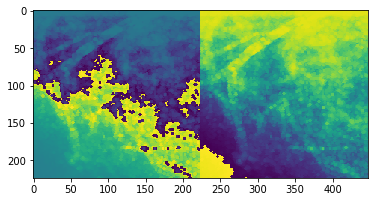

In [24]:
arr=newcsv.pixel_array
img=arr[9]
whole=[img,img-img.mean().astype(np.uint8)]
plt.imshow(np.hstack(whole))